<a href="https://colab.research.google.com/github/SANGDONKIM/pytorch_d2l/blob/main/DGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dgl 

     |████████████████████████████████| 4.4MB 10.5MB/s 


In [2]:
import dgl
import torch as th

Using backend: pytorch


In [3]:
u, v = th.tensor([0, 0, 0, 1]), th.tensor([1, 2, 3, 3])
g = dgl.graph((u, v))
print(g)

Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})


In [4]:
print(g.nodes())

tensor([0, 1, 2, 3])


In [5]:
print(g.edges())

(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]))


In [6]:
print(g.edges(form='all')) # edge, node, edge id 출력 

(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]), tensor([0, 1, 2, 3]))


In [7]:
g = dgl.graph((u, v), num_nodes=8)

In [8]:
bg = dgl.to_bidirected(g)

In [9]:
bg.edges()

(tensor([0, 0, 0, 1, 1, 2, 3, 3]), tensor([1, 2, 3, 0, 3, 0, 0, 1]))

In [12]:
edges = th.tensor([2, 5, 3]), th.tensor([3, 5, 0])
print(edges)

(tensor([2, 5, 3]), tensor([3, 5, 0]))


# DGL 데이터 생성 시 유의사항 

- node, edge 의 데이터 타입이 같아야함 
- 64bit에서는 $2^{63} - 1$까지의 node, edge 를 다룰 수 있음 
- 64bit에서는 $2^{31} - 1$까지의 node, edge 를 다룰 수 있음
- 생성하려는 데이터의 크기를 대략적으로 파악하고, 데이터 크기에 맞는 타입을 지정해주어야 속도 측면에서 효과적임 


In [14]:
g64 = dgl.graph(edges) # DGL 은 int64가 default임 
print(g64)

Graph(num_nodes=6, num_edges=3,
      ndata_schemes={}
      edata_schemes={})


In [16]:
g32 = dgl.graph(edges, idtype=th.int32)
g32.idtype

torch.int32

In [18]:
g64_2 = g32.long()
g64_2.idtype

torch.int64

In [20]:
g32_2 = g64.int()
g32_2.idtype

torch.int32

# Node and Edge Features 

In [38]:
g = dgl.graph(([0, 0, 1, 5], [1, 2, 2, 0]))
g

Graph(num_nodes=6, num_edges=4,
      ndata_schemes={}
      edata_schemes={})

In [39]:

g.ndata['x'] = th.ones(g.num_nodes(), 3) # g.num_nodes() = 6, (6,3) 1 matrix 생성
g.edata['x'] = th.ones(g.num_edges(), dtype = th.int32)
g


Graph(num_nodes=6, num_edges=4,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'x': Scheme(shape=(), dtype=torch.int32)})

In [40]:
g.ndata['y'] = th.randn(g.num_nodes(), 5)
g

Graph(num_nodes=6, num_edges=4,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'y': Scheme(shape=(5,), dtype=torch.float32)}
      edata_schemes={'x': Scheme(shape=(), dtype=torch.int32)})

In [41]:
g.ndata['x'][1]
g.edata['x'][th.tensor([0, 3])]

tensor([1, 1], dtype=torch.int32)

In [47]:
edges = th.tensor([0, 0, 0, 1]), th.tensor([1, 2, 3, 3])
weights = th.tensor([0.1, 0.6, 0.9, 0.7])
g = dgl.graph(edges)
g.edata['w'] = weights # edge에 w 이름 부여하고, 가중치 부여 
g

Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)})

# Creating graphs from external libraries 
- 파이썬의 다른 graph 관련 패키지에서 생성한 graph를 dgl에 맞게 바꿀 수 있음 
- dgl은 항상 directed 그래프를 구축하기 때문에 주의 필요 

In [7]:
import scipy.sparse as sp
import networkx as nx

In [49]:
spmat = sp.rand(100, 100, density=0.05) # 5% nonzero entries
dgl.from_scipy(spmat)  

Graph(num_nodes=100, num_edges=500,
      ndata_schemes={}
      edata_schemes={})

In [50]:
nx_g = nx.path_graph(5) # a chain 0-1-2-3-4
dgl.from_networkx(nx_g) # from networkx

Graph(num_nodes=5, num_edges=8,
      ndata_schemes={}
      edata_schemes={})

In [51]:
nxg = nx.DiGraph([(2, 1), (1, 2), (2, 3), (0, 0)])
dgl.from_networkx(nxg)

Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})

# Heterogeneous Graphs 
- node의 종류가 다른 그래프를 의미
- node의 종류가 하나일 때는 homogeneous graph라고 함 

In [52]:
graph_data = {
    ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])), 
    ('drug', 'interacts', 'gene'): (th.tensor([0, 1]), th.tensor([2, 3])), 
    ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2])) 
}

In [72]:
g = dgl.heterograph(graph_data)
g.ntypes
g.etypes
g.canonical_etypes
g.num_edges

<bound method DGLHeteroGraph.num_edges of Graph(num_nodes={'disease': 3, 'drug': 3, 'gene': 4},
      num_edges={('drug', 'interacts', 'drug'): 2, ('drug', 'interacts', 'gene'): 2, ('drug', 'treats', 'disease'): 1},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'gene', 'interacts'), ('drug', 'disease', 'treats')])>

## Homogeneous graph 


In [59]:
u
v
dgl.heterograph({('node_type', 'edge_type', 'node_type'): (u, v)})

Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})

In [60]:
dgl.heterograph({('source_type', 'edge_type', 'destination_type'): (u, v)})

Graph(num_nodes={'destination_type': 4, 'source_type': 2},
      num_edges={('source_type', 'edge_type', 'destination_type'): 4},
      metagraph=[('source_type', 'destination_type', 'edge_type')])

In [63]:
g
g.metagraph().edges()

OutMultiEdgeDataView([('drug', 'drug'), ('drug', 'gene'), ('drug', 'disease')])

In [67]:
# Get the number of all nodes in the graph
g.num_nodes()

# Get the number of drug nodes
g.num_nodes('drug')

# Nodes of different types have separate IDs,
# hence not well-defined without a type specified
g.nodes('drug')


tensor([0, 1, 2])

In [71]:
g.nodes['drug'].data['hv'] = th.ones(3, 1)
g.nodes['drug'].data['hv']

# Set/get feature 'he' for edge of type 'treats'
g.edges['treats'].data['he'] = th.zeros(1, 1)
g.edges['treats'].data['he']


tensor([[0.]])

In [ ]:
g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'is similar', 'drug'): (th.tensor([0, 1]), th.tensor([2, 3]))
})
g.nodes()

# To set/get feature with a single type, no need to use the new syntax
g.ndata['hv'] = th.ones(4, 1)

# Using DGLGraph on a GPU 


In [9]:
u, v = th.tensor([0, 1, 2]), th.tensor([2, 3, 4])
g = dgl.graph((u, v))
g


Graph(num_nodes=5, num_edges=3,
      ndata_schemes={}
      edata_schemes={})

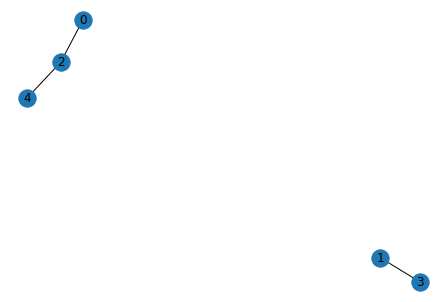

In [10]:
import networkx as nx
nx_G = g.to_networkx().to_undirected()
nx.draw(nx_G, with_labels = True)

In [11]:
g.ndata['x'] = th.randn(5, 3)

In [12]:
g.device # CPU 

device(type='cpu')

In [14]:
import torch
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))
# cuda_g = g.to('cuda:0')  # accepts any device objects from backend framework
# cuda_g.device

Torch version:1.8.1+cu101
cuda version: 10.1
cudnn version:7603


# DGL at a Glance 

In [11]:
import dgl
import numpy as np

In [18]:
def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33]) # (78,)
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst]) # (156, )
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [19]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


/usr/local/lib/python3.7/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [30]:
import networkx as nx 
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G) # layout은 그래프 생성에 크게 중요하지 않은 것 같음. 그냥 kamada를 많이 씀 


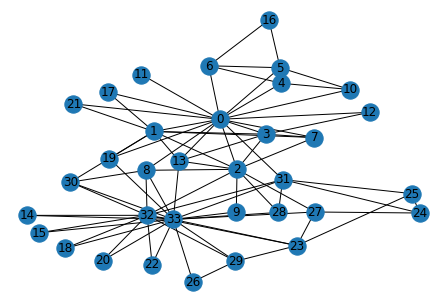

In [36]:
nx.draw(nx_G, pos, with_labels=True)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

Parameter containing:
tensor([[ 0.2684,  1.1483,  1.4805,  0.3588, -1.2152],
        [ 1.2872, -0.1057, -0.6128,  0.1582, -0.6055],
        [-0.1842,  0.3324, -0.7890, -0.6023,  0.2304],
        [ 1.4548, -3.0561,  0.3361,  0.7321,  1.3590],
        [ 1.8652,  0.5010, -0.6500,  0.1829, -0.2025],
        [-1.4285,  0.3359,  0.1831, -0.2239, -1.1845],
        [-0.7028,  1.0517, -0.0727,  1.3053,  0.7581],
        [ 0.0987, -0.6643, -0.0469,  0.4092, -1.0142],
        [-0.3587,  1.6041, -1.0604, -1.3248,  0.3254],
        [-0.3101, -0.6654,  0.9126,  1.2764, -2.2152],
        [ 0.0385, -0.9780, -0.3465, -1.3620, -0.2846],
        [ 0.5152, -0.7543, -2.6159,  0.3531, -0.8269],
        [-1.1672,  0.3835, -0.5273, -0.3486,  0.1404],
        [-1.7748, -0.1261, -0.6390,  0.7438,  0.1984],
        [ 1.3835, -0.9859, -0.0900,  1.3520,  0.1847],
        [-0.7896, -0.0849,  0.3300,  0.0897, -0.6924],
        [-0.5792,  1.0855, -0.3856, -0.0231,  0.4672],
        [-1.3046,  0.8860, -0.9827,  0.1786

In [43]:
# print out node 2's input feature
print(G.ndata['feat'][2])

tensor([-0.1842,  0.3324, -0.7890, -0.6023,  0.2304], grad_fn=<SelectBackward>)


In [44]:
# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([[ 0.0385, -0.9780, -0.3465, -1.3620, -0.2846],
        [ 0.5152, -0.7543, -2.6159,  0.3531, -0.8269]],
       grad_fn=<IndexBackward>)


In [45]:
from dgl.nn.pytorch import GraphConv

In [47]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)
net

GCN(
  (conv1): GraphConv(in=5, out=5, normalization=both, activation=None)
  (conv2): GraphConv(in=5, out=2, normalization=both, activation=None)
)

In [50]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [51]:
import itertools

In [55]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.0948
Epoch 1 | Loss: 0.0849
Epoch 2 | Loss: 0.0757
Epoch 3 | Loss: 0.0673
Epoch 4 | Loss: 0.0597
Epoch 5 | Loss: 0.0528
Epoch 6 | Loss: 0.0466
Epoch 7 | Loss: 0.0411
Epoch 8 | Loss: 0.0362
Epoch 9 | Loss: 0.0318
Epoch 10 | Loss: 0.0280
Epoch 11 | Loss: 0.0245
Epoch 12 | Loss: 0.0215
Epoch 13 | Loss: 0.0189
Epoch 14 | Loss: 0.0166
Epoch 15 | Loss: 0.0146
Epoch 16 | Loss: 0.0129
Epoch 17 | Loss: 0.0114
Epoch 18 | Loss: 0.0101
Epoch 19 | Loss: 0.0089
Epoch 20 | Loss: 0.0080
Epoch 21 | Loss: 0.0071
Epoch 22 | Loss: 0.0064
Epoch 23 | Loss: 0.0057
Epoch 24 | Loss: 0.0052
Epoch 25 | Loss: 0.0047
Epoch 26 | Loss: 0.0043
Epoch 27 | Loss: 0.0039
Epoch 28 | Loss: 0.0036
Epoch 29 | Loss: 0.0033
Epoch 30 | Loss: 0.0031
Epoch 31 | Loss: 0.0028
Epoch 32 | Loss: 0.0026
Epoch 33 | Loss: 0.0025
Epoch 34 | Loss: 0.0023
Epoch 35 | Loss: 0.0022
Epoch 36 | Loss: 0.0020
Epoch 37 | Loss: 0.0019
Epoch 38 | Loss: 0.0018
Epoch 39 | Loss: 0.0017
Epoch 40 | Loss: 0.0016
Epoch 41 | Loss: 0.0015
Ep

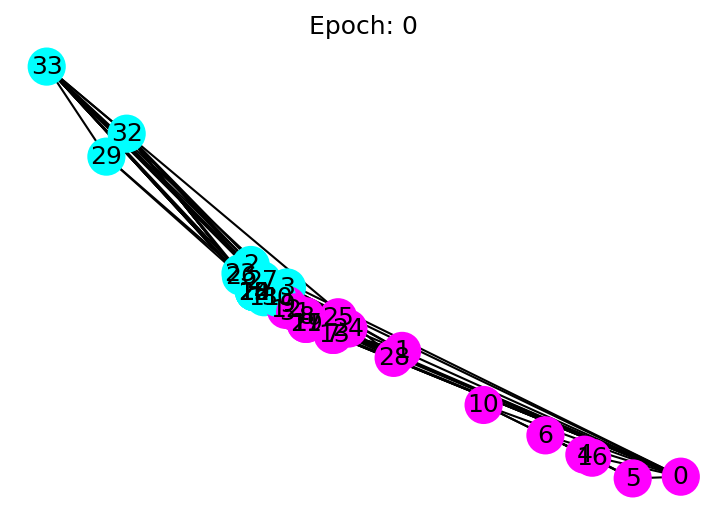

In [58]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch


In [65]:
import urllib.request
import pandas as pd

urllib.request.urlretrieve(
    'https://data.dgl.ai/tutorial/dataset/members.csv', './members.csv')
urllib.request.urlretrieve(
    'https://data.dgl.ai/tutorial/dataset/interactions.csv', './interactions.csv')

members = pd.read_csv('./members.csv')
interactions = pd.read_csv('./interactions.csv')

members.head()

interactions.head()

,Src,Dst,Weight
0,0,1,0.043591
1,0,2,0.282119
2,0,3,0.370293
3,0,4,0.730570
4,0,5,0.821187


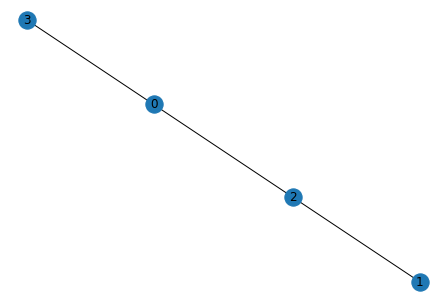

In [67]:
import networkx as nx
g = dgl.graph([(0, 2), (0, 3), (1, 2)])
nx_G = g.to_networkx().to_undirected()
nx.draw(nx_G, with_labels = True)

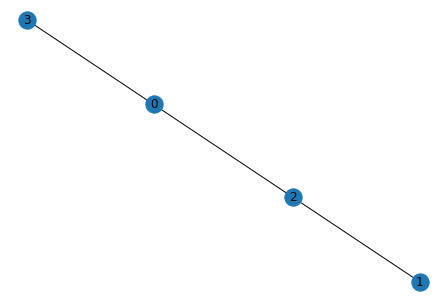

In [68]:
u = [0, 0, 1]
v = [2, 3, 2]
g = dgl.graph((u, v))
nx_G = g.to_networkx().to_undirected()
nx.draw(nx_G, with_labels = True)

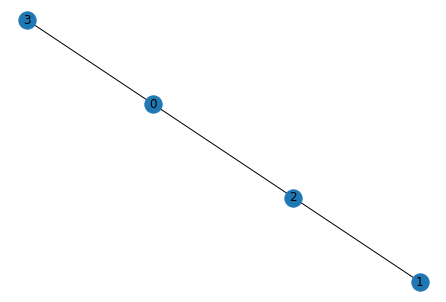

In [70]:
u = torch.tensor([0, 0, 1])
v = torch.tensor([2, 3, 2])
g = dgl.graph((u, v))
nx_G = g.to_networkx().to_undirected()
nx.draw(nx_G, with_labels = True)